# 5.이미지 분류
## 5.1 개/고양이 예를 반려동물 품종으로 확장하기

In [1]:
# load dataset
from fastai.vision.all import *
path = untar_data(URLs.PETS)

path.ls()

(#2) [Path('/home/shyeon/.fastai/data/oxford-iiit-pet/annotations'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images')]

In [2]:
(path/"images").ls()

(#7393) [Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_78.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/leonberger_137.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/leonberger_92.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/samoyed_48.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/newfoundland_48.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_32.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_15.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/Russian_Blue_142.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/american_bulldog_67.jpg'),Path('/home/shyeon/.fastai/data/oxford-iiit-pet/images/havanese_35.jpg')...]

In [3]:
# test one file
fname = (path/"images").ls()[0]
re.findall(r"(.+)_\d+.jpg$", fname.name)  # 하나 이상의 숫자와 확장자 이전의 모든 문자 

['american_pit_bull_terrier']

In [4]:
# DataBlock
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r"(.+)_\d+.jpg$"), "name"),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [5]:
item_tfms=Resize(460)  # 전체 너비나 높이를 기준으로 잘라내는 단계
batch_tfms=aug_transforms(size=224, min_scale=0.75)  # 임의의 부분을 잘라낸 후 증강하는 단계

## 5.2 사전 크기 조절

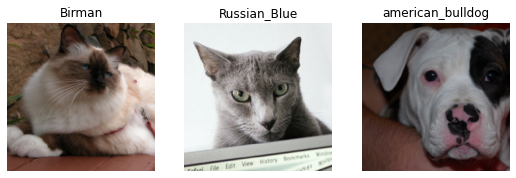

In [6]:
dls.show_batch(nrows=1, ncols=3)